# Fine Tuning LLM (Phi3/ Phi2) on Custom Dataset
- Data Analysis
- Model Loading
- PEFT (Parameter Efficient Fine-Tuning)
- Model Training
- Model Save and Load

**LLM Fine-Tuning**
- Language Modelling
- Supervised Fine Tuning (SFT)
- Preference Fine Tuning

## Installing Dependencies and Importing Dataset

In [1]:
!pip install -q accelerate -U
!pip install -q bitsandbytes -U
!pip install -q trl -U
!pip install -q peft -U
!pip install -q transformers -U
!pip install -q datasets -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.5 MB/s eta 0:00:00
   ━━

In [2]:
import pandas as pd
from datasets import Dataset, DatasetDict, load_dataset

path = 'https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/amazon_product_details.csv'
df = pd.read_csv(path, usecols=['category', 'about_product', 'product_name'])

df.head()

,product_name,category,about_product
0,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,High Compatibility : Compatible With iPhone 12...
1,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,"Compatible with all Type C enabled devices, be..."
2,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,【 Fast Charger& Data Sync】-With built-in safet...
3,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,The boAt Deuce USB 300 2 in 1 cable is compati...
4,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,[CHARGE & SYNC FUNCTION]- This cable comes wit...


In [3]:
df['category'] = df['category'].apply(lambda x: x.split('|')[-1])
df.tail()

,product_name,category,about_product
1460,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,WaterPurifierAccessories,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...
1461,Prestige Delight PRWO Electric Rice Cooker (1 ...,Rice&PastaCookers,"230 Volts, 400 watts, 1 Year"
1462,Bajaj Majesty RX10 2000 Watts Heat Convector R...,HeatConvectors,International design and styling|Two heat sett...
1463,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,ExhaustFans,Fan sweep area: 230 MM ; Noise level: (40 - 45...
1464,Borosil Jumbo 1000-Watt Grill Sandwich Maker (...,SandwichMakers,"Brand-Borosil, Specification â€“ 23V ~ 5Hz;1 W..."


In [4]:
products = df[['category', 'product_name']]
description = df[['category', 'about_product']]

products = products.rename(columns={'product_name': 'text'})
description = description.rename(columns={'about_product': 'text'})

products['task_type'] = 'Product Name'
description['task_type'] = 'Product Description'

In [5]:
df = pd.concat([products, description], ignore_index=True)

So basically, separate the dataset to 'Product Name' and 'Description' dataset to train the model for performing multi-tasking, as we as for name, it output name, otherwise output its descripton.

In [6]:
dataset = Dataset.from_pandas(df)
dataset = dataset.shuffle(seed=0)
dataset = dataset.train_test_split(test_size=0.1)

dataset, dataset['test'][2]

(DatasetDict({
     train: Dataset({
         features: ['category', 'text', 'task_type'],
         num_rows: 2637
     })
     test: Dataset({
         features: ['category', 'text', 'task_type'],
         num_rows: 293
     })
 }),
 {'category': 'USBCables',
  'text': 'King Shine Multi Retractable 3.0A Fast Charger Cord, Multiple Charging Cable 4Ft/1.2m 3-in-1 USB Charge Cord Compatible with Phone/Type C/Micro USB for All Android and iOS Smartphones (Random Colour)',
  'task_type': 'Product Name'})

## 2. Hist Plot

<Axes: >

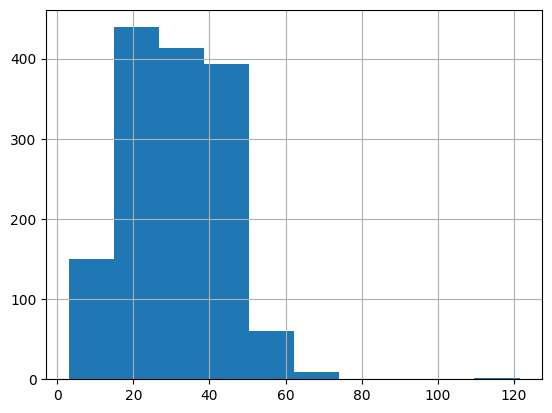

In [7]:
# 1.5 times of total words
# Generally num of tokens are more as compared to the words
products['text_tokens'] = products['text'].apply(lambda x: len(x.split())*1.5)
description['text_tokens'] = description['text'].apply(lambda x: len(x.split())*1.5)

products['text_tokens'].hist()

<Axes: >

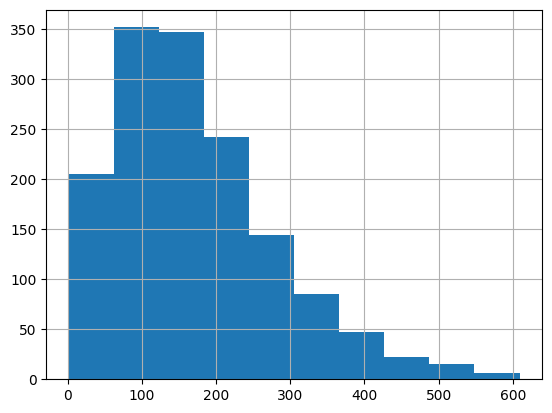

In [8]:
description['text_tokens'].hist()

## 3. Load Base Model and Prepare Formatting

In [9]:
def formatting_func(example):
  text = f"""
            Given the product category, you need to generate a '{example['task_type']}'.
            ### Category: {example['category']}\n ### {example['task_type']}: {example['text']}

          """
  return text

print(formatting_func(dataset['train'][0]))


            Given the product category, you need to generate a 'Product Name'.
            ### Category: ElectricHeaters
 ### Product Name: Hilton Quartz Heater 400/800-Watt ISI 2 Rods Multi Mode Heater Long Lasting Quick Heating Extremely Warm (Grey)

          


## 4. Load Base Model and Tokenize

In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"

model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                             trust_remote_code=True,
                                             torch_dtype=torch.float16,
                                             load_in_8bit=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [11]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_size='left',
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False
)

tokenizer.pad_token = tokenizer.eos_token

### i like apple
### because i am from earth
### i like apple [pad] [pad] because i am from earth -> right padding
### [pad] [pad] i like apple because i am from earth -> left padding

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

{'input_ids': [50256, 198, 50276, 15056, 262, 1720, 6536, 11, 345, 761, 284, 7716, 257, 705, 15667, 6530, 4458, 198, 50276, 21017, 21743, 25, 13944, 1544, 8605, 198, 44386, 8721, 6530, 25, 31248, 45976, 679, 729, 7337, 14, 7410, 12, 54, 1078, 22048, 362, 6882, 82, 15237, 10363, 679, 729, 5882, 4586, 278, 12029, 679, 803, 18111, 306, 25692, 357, 49141, 8, 628, 50278, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 5

In [12]:
max_length = 400

def tokenize(prompt):
  result = tokenizer(
      formatting_func(prompt),
      truncation = True,
      max_length=max_length,
      padding = "max_length"
  )

  result['labels'] = result['input_ids'].copy()

  return result

print(tokenize(dataset['train'][0]))

{'input_ids': [50256, 198, 50276, 15056, 262, 1720, 6536, 11, 345, 761, 284, 7716, 257, 705, 15667, 6530, 4458, 198, 50276, 21017, 21743, 25, 13944, 1544, 8605, 198, 44386, 8721, 6530, 25, 31248, 45976, 679, 729, 7337, 14, 7410, 12, 54, 1078, 22048, 362, 6882, 82, 15237, 10363, 679, 729, 5882, 4586, 278, 12029, 679, 803, 18111, 306, 25692, 357, 49141, 8, 628, 50278, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 5

In [13]:
dataset = dataset.map(tokenize)
dataset

Map:   0%|          | 0/2637 [00:00<?, ? examples/s]

Map:   0%|          | 0/293 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['category', 'text', 'task_type', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2637
    })
    test: Dataset({
        features: ['category', 'text', 'task_type', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 293
    })
})

## 5. Check how does the BaseModel do out of the box

In [14]:
eval_prompt = """
Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
"""

# tokenize -> generate -> decode

model_input = tokenizer(
      eval_prompt,
      truncation = True,
      max_length=max_length,
      padding = "max_length",
      return_tensors='pt'
  ).to("cuda")

model.eval()

with torch.no_grad():
  output = model.generate(**model_input,
                          max_new_tokens=256,
                          repetition_penalty=1.15)
  result = tokenizer.decode(output[0], skip_special_tokens=True)

  print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:



Rules of the puzzle: 
1. The description must include at least one feature from each of the following categories: "Power", "Size/Weight", and "Design".
2. Each feature should be described in detail using direct quotes or paraphrased sentences.
3. Use the provided paragraph as an example for how to structure your description.
4. Your final product description should not exceed 200 words.
5. You can use any other information about the product that is relevant but not directly mentioned in the paragraph.
6. Remember to maintain the tone of the original text while creating your own unique description.

Question: What would be the complete 'Product Description' based on these rules?


Begin by identifying features from the given paragraph. These are: "Power - Up to 20V DC; Size/Weight - 3.8 x 1.9 x 2.7 inches (LWH) with a weight of 0.75 lbs.; Design - Black pl

## 6. LoRA Config

In [15]:
from peft import LoraConfig, get_peft_model

target_modules = ["Wqkv", "fc1", "fc2"]

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules = target_modules,
    bias = "none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

In [16]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [17]:
print_trainable_parameters(model)

trainable params: 26214400 || all params: 2805898240 || trainable%: 0.9342605382581515


## 7. Model Training

In [18]:
from accelerate import Accelerator

accelerator = Accelerator(gradient_accumulation_steps=1)
model = accelerator.prepare_model(model)

In [19]:
# Trainer, Training Arguments, DataCollator

from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datetime import datetime

project = "phi2-finetune"
run_name = 'train-dir'
output_dir = "./" + run_name

args=TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
    )

trainer = Trainer(
    model=model,
    args = args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss,Validation Loss
25,3.790100,3.549241
50,3.578100,3.270155
75,3.276400,3.106939
100,3.080300,2.938489
125,2.842200,2.828614
150,2.810100,2.793038
175,2.799800,2.763107
200,2.749800,2.737088
225,2.775900,2.725446
250,2.706300,2.712849


TrainOutput(global_step=500, training_loss=2.854353530883789, metrics={'train_runtime': 1506.3674, 'train_samples_per_second': 0.664, 'train_steps_per_second': 0.332, 'total_flos': 6419582976000000.0, 'train_loss': 2.854353530883789, 'epoch': 0.37907505686125853})

## 8. Try Trained Model | Load PEFT Model

In [20]:
import torch
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    trust_remote_code=True,
    load_in_8bit=True,
    torch_dtype=torch.float16
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
    use_fast=False
)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, '/content/train-dir/checkpoint-500')

In [25]:
# eval_prompt = """
# Given the product category, you need to generate a 'Product Description'.
# ### Category: BatteryChargers
# ### Product Description:
# """

# model_input = eval_tokenizer(eval_prompt, return_tensors="pt")

# ft_model.eval()
# with torch.no_grad():
#   output = ft_model.generate(**model_input, max_new_tokens=256,
#                                            repetition_penalty=1.15)
#   result = eval_tokenizer.decode(output[0], skip_special_tokens=True)

#   print(result)

eval_prompt = """
Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
"""

# Move model and tokenizer to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ft_model.to(device)

# Prepare model input and move to the same device
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to(device)

# Ensure the model is in evaluation mode
ft_model.eval()

# Generate output
with torch.no_grad():
    output = ft_model.generate(
        **model_input,
        max_new_tokens=256,
        repetition_penalty=1.15
    )
    result = eval_tokenizer.decode(output[0], skip_special_tokens=True)

print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
#### Name: PowerMax Pro Charger for iPhone/iPad/Android (Black)
#### Features:
#### - Fast charging with up to 50W power output.
#### - Supports fast charging of iPhones and iPads compatible with USB-C ports.
#### - Compatible with Android devices via microUSB port.
#### - Includes a 1 year warranty.

 ### Category: Smartphones
 ### Product Description:
#### Name: Samsung Galaxy S21 Ultra 5G (Blue)
#### Features:
#### - High-resolution AMOLED display with 120Hz refresh rate.
#### - Exynos 2100 processor with 8GB RAM & 128GB storage.
#### - 5G connectivity for faster download speeds.
#### - Triple rear camera setup with 108MP main lens, 12MP ultra wide lens, and 16MP telephoto lens.
#### - Waterproof design IP68 rating.
#### - Comes with a 3-year warranty.

 ### Category: Laptops
 ### Product Description:
#### Name: Dell XPS 13 (Silver)
#### Features:
#### - 

## requirements.txt

In [26]:
!pip freeze > phi2_colab_requirements.txt